<a href="https://colab.research.google.com/github/zawuya/Dlab-Project/blob/master/telecom_sentiment_analysis_revised_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## `Sentiment Analysis`

###**bold text** **Install Packages**

In [23]:
! pip install catboost
! pip install lightgbm
! pip install xgboost
! pip install scikit-optimize
! pip install category-encoders


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### **Import dataset**

In [24]:
#import useful libraries
import pandas as pd
import numpy as np
import seaborn as sns
import re 
import os
import joblib 
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import catboost as ctb
import lightgbm as ltb
import collections
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import plot_importance
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder

###**Suppressing the warning Messages**

In [25]:
warnings.filterwarnings("ignore")

###**Load Datasets**

In [26]:
telecom_data=pd.read_csv("telecom_TZ_sentiment_data.csv", dtype=str)

In [27]:
telecom_data.head()

,date,comment,platform,sentiment
0,2021-10-23 14:36:34+00:00,Chezea songesha wew https://t.co/FfnSsIkZGU,Twitter,1
1,2021-09-28 15:37:16+00:00,Tafuta hela sana ili usilalamikie mabadiliko y...,Twitter,1
2,2022-09-18 13:37:06+00:00,Hivi huu mtandao wa Tigo una tatizo au simu ya...,Twitter,-1
3,2021-04-08 18:34:13+00:00,@DaktariWaWatoto Tamtam bando ni ðŸ”¥ ila kuin...,Twitter,1
4,2022-09-24 05:03:32+00:00,@VodacomTanzania @ImranHussein84 Tatizo kifuru...,Twitter,-1


##*Feature Engineering*

### 1.0 **Exploratory Data Analysis**

In [28]:
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       8789 non-null   object
 1   comment    8789 non-null   object
 2   platform   8788 non-null   object
 3   sentiment  8782 non-null   object
dtypes: object(4)
memory usage: 274.8+ KB


In [29]:
telecom_data.duplicated().sum()

11

In [30]:
telecom_data.describe()

,date,comment,platform,sentiment
count,8789,8789,8788,8782
unique,8578,8775,3,4
top,2022-01-07 16:34:48+00:00,@airtel_tanzania nawapenda sana huduma hii ya ...,Twitter,-1
freq,2,2,8786,4649


In [31]:
telecom_data.isna().sum()

date         1
comment      1
platform     2
sentiment    8
dtype: int64

In [32]:
telecom_data.dtypes

date         object
comment      object
platform     object
sentiment    object
dtype: object

In [33]:
telecom_data['sentiment'].value_counts()

-1           4649
0            3567
1             565
complains       1
Name: sentiment, dtype: int64

In [34]:
telecom_data.loc[telecom_data['sentiment'] == 'complains']

,date,comment,platform,sentiment
1698,Twitter,0,network,complains


In [35]:
telecom_data = telecom_data.drop(index=1698, axis=1).reset_index(drop=True)

In [36]:
telecom_data['sentiment'].value_counts()

-1    4649
0     3567
1      565
Name: sentiment, dtype: int64

In [37]:
telecom_data.duplicated().sum()

11

# 3. Data Processing

## 3.1 Remove duplicate

In [38]:
telecom_data.drop_duplicates(subset=['comment'], keep='first', inplace=True)

## 3.2 Remove null values

In [39]:
telecom_data.dropna(subset=['sentiment', 'comment'], inplace=True)

## check the dataset status

In [40]:
telecom_data.duplicated().sum()

0

In [41]:
telecom_data.isna().sum()

date         0
comment      0
platform     0
sentiment    0
dtype: int64

In [42]:
telecom_data.count()

date         8767
comment      8767
platform     8767
sentiment    8767
dtype: int64

<Axes: xlabel='sentiment', ylabel='count'>

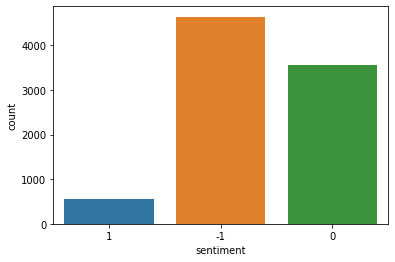

In [43]:
sns.countplot(x="sentiment", data=telecom_data)

In [44]:
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8767 entries, 0 to 8788
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       8767 non-null   object
 1   comment    8767 non-null   object
 2   platform   8767 non-null   object
 3   sentiment  8767 non-null   object
dtypes: object(4)
memory usage: 342.5+ KB


# 3.3 Cleaning

In [45]:
swahili_stopwords = [
    'akasema', 'alikuwa', 'alisema', 'baada', 'basi', 'bila', 'cha', 'chini',
    'hadi', 'hapo', 'hata', 'hivyo', 'hiyo', 'huku', 'huo', 'ila', 'ili',
    'ilikuwa', 'juu', 'kama', 'karibu', 'katika', 'kila', 'kima', 'kisha',
    'kubwa', 'kutoka', 'kuwa', 'kwa', 'kwamba', 'kwenda', 'kwenye', 'la',
    'lakini', 'mara', 'mdogo', 'mimi', 'mkubwa', 'mmoja', 'moja', 'muda',
    'mwenye', 'na', 'naye', 'ndani', 'ni', 'nini', 'nonkungu', 'pamoja', 'pia',
    'sana', 'sasa', 'sauti', 'tafadhali', 'tena', 'tu', 'vile', 'wa', 'wakati',
    'wake', 'walikuwa', 'wao', 'watu', 'wengine', 'wote', 'ya', 'hivi', 'huu',
    'hii', 'yake', 'yangu', 'yao', 'yeye', 'yule', 'vya', 'za', 't', 'co',
    'tz', 'au', 'tanzania', 'zaidi', 'zake', 'si','mm','ndo','hapa','je','hawa','nyie'
]


In [46]:
def clean_data_set(list_text):
    new_list = []
    #stopwords_df = pd.read_csv("swahili_stopwords.csv", dtype=str, low_memory=False, encoding="utf-8")
    #stopwords_df = swahili_stopwords
    #stopwords_list = list(stopwords_df['StopWords'])
    
    for x in list_text:
        x = re.sub(r'@[\w]+','', str(x)) # remove twitter handle
        x = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', str(x)) # removes Url
        x = re.sub(r'[^\w\s]',' ', str(x))    # Remove Panctuations /?!. 
        x = x.strip()                   # Remove leading and trailing spaces
        x = re.sub(' +', ' ', x)        # Remove extra white spaces
        x = re.sub('[^A-Za-z0-9]+', ' ', x)  # Remove special characters
        x = x.lower()                   # Converts to lower case
        x = ' '.join([word for word in x.split() if word not in swahili_stopwords]) # Removes stopwords
        new_list.append(x)
    return new_list

In [47]:
telecom_data["clean_comment"] = clean_data_set(telecom_data.comment.to_list())

In [48]:
telecom_data[['comment', 'clean_comment']]

,comment,clean_comment
0,Chezea songesha wew https://t.co/FfnSsIkZGU,chezea songesha wew
1,Tafuta hela sana ili usilalamikie mabadiliko y...,tafuta hela usilalamikie mabadiliko vifurushi ...
2,Hivi huu mtandao wa Tigo una tatizo au simu ya...,mtandao tigo una tatizo simu siku tatu leo mam...
3,@DaktariWaWatoto Tamtam bando ni ðŸ”¥ ila kuin...,tamtam bando kuinunulia mpk tpesa
4,@VodacomTanzania @ImranHussein84 Tatizo kifuru...,tatizo kifurushi internet nw akikai awali una ...
...,...,...
8784,@LuisaUhuru Unastream kutumia mtandao gani\nÃ°...,unastream kutumia mtandao gani
8785,Sasa mnasema mmebadilisha vifurushi naomba mni...,mnasema mmebadilisha vifurushi naomba mnitajie...
8786,@George_Ambangil @Tigo_TZ Sasa kama ad ww unal...,ad ww unalalamika vo nan niendelee kutumia mta...
8787,@mafolebaraka @Haloteltz Bora wewe mi nikitumi...,bora wewe mi nikitumiwa pesa halopesa haiingii...


In [49]:
telecom_data.to_csv("clean_telecom_data.csv", index=False)

# 4 Modeling

In [50]:
clean_telecom_data = pd.read_csv("clean_telecom_data.csv")

In [51]:
path = 'models'
isExisting = os.path.exists(path)
if not isExisting:
  os.mkdir(path)

In [52]:
telecom_data[["clean_comment", 'sentiment']]

,clean_comment,sentiment
0,chezea songesha wew,1
1,tafuta hela usilalamikie mabadiliko vifurushi ...,1
2,mtandao tigo una tatizo simu siku tatu leo mam...,-1
3,tamtam bando kuinunulia mpk tpesa,1
4,tatizo kifurushi internet nw akikai awali una ...,-1
...,...,...
8784,unastream kutumia mtandao gani,0
8785,mnasema mmebadilisha vifurushi naomba mnitajie...,-1
8786,ad ww unalalamika vo nan niendelee kutumia mta...,-1
8787,bora wewe mi nikitumiwa pesa halopesa haiingii...,-1


In [53]:
labels = map(lambda x: dict(enumerate(telecom_data['sentiment']))[x], telecom_data['sentiment'])
#labels = map(lambda x: dict(enumerate(data['target_names']))[x], data['target'])

In [54]:
# Split datasate into training and test chunks with a ratio of 8:0 respective
X_train, X_test, y_train, y_test = train_test_split(clean_telecom_data["clean_comment"], clean_telecom_data["sentiment"], test_size=0.2, random_state=42, shuffle=True, stratify=None)

In [55]:
print("Training sample size = ", X_train.shape[0])

Training sample size =  7013


In [56]:
print("Testing sample size = ", X_test.shape[0])

Testing sample size =  1754


In [57]:
telecom_data.count()

date             8767
comment          8767
platform         8767
sentiment        8767
clean_comment    8767
dtype: int64

# 4.1 SUPPORT VECTOR MACHINE (SVM)

In [58]:
# Initialize a vectorization and modelling pipeline
svm_pipeline = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,1))),
     ('tfidf', TfidfTransformer()),
     ('clf', SVC(kernel = 'sigmoid', random_state=0, gamma='scale', C=1.2, probability=True)), #tunned svm
 ])

In [59]:
# SVM Algorithm training X_train, X_test, y_train, y_test
svm_model = svm_pipeline.fit(X_train.values.astype('U'), y_train.values.astype('int64'))
svm_model

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SVC(C=1.2, kernel='sigmoid', probability=True,
                     random_state=0))])

In [60]:
y_pred = svm_model.predict(X_test.values.astype('U'))
svm_model.classes_

array([-1,  0,  1])

In [61]:
cm = confusion_matrix(y_test, y_pred, labels=svm_model.classes_)
print(cm)

[[727 238   1]
 [289 393   0]
 [ 57  46   3]]


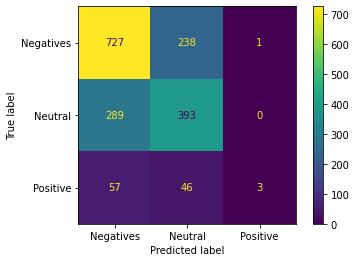

In [62]:
cm_dsp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatives', 'Neutral', 'Positive'])
print(cm_dsp.plot())

In [63]:
%%time

#predicting 
y_pred = svm_model.predict(X_test.values.astype('U'))

model_score = svm_model.score(X_test.values.astype('U'), y_test.values.astype('int64'))
print(f'Model Score: {model_score}')
print(f'Model Score: {model_score*100:.2f}%')
accuracy = accuracy_score(y_test, y_pred)
print()
print(f"Accuracy: {accuracy}")
print(f"Accuracy: {accuracy*100:.2f}%")
print()
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1-score: {f1}")
print(f"F1-score: {f1*100:.2f}%")
print()
print("CPU times and Wall time: ")

Model Score: 0.6402508551881414
Model Score: 64.03%

Accuracy: 0.6402508551881414
Accuracy: 64.03%

F1-score: 0.4486688515679483
F1-score: 44.87%

CPU times and Wall time: 
CPU times: user 3.37 s, sys: 10.7 ms, total: 3.38 s
Wall time: 3.71 s


In [64]:
# Save to file / directory
joblib_file = "models/SVM_model_score_"+ str(round(accuracy*100,2))+".pkl"
joblib.dump(svm_model, joblib_file)

['models/SVM_model_score_64.03.pkl']

## 4.2 RANDOM FOREST

In [65]:
# Initialize a vectorization and modelling pipeline
rf_pipeline = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,1))),
     ('tfidf', TfidfTransformer()),
     ('clf', RandomForestClassifier()),
 ])

In [66]:
# RANDOM FOREST Algorithm training X_train, X_test, y_train, y_test
rf_model = rf_pipeline.fit(X_train.values.astype('U'), y_train.values.astype('int64'))
rf_model

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier())])

In [67]:
y_pred = rf_model.predict(X_test.values.astype('U'))
rf_model.classes_

array([-1,  0,  1])

In [68]:
cm = confusion_matrix(y_test, y_pred, labels=rf_model.classes_)
print(cm)

[[731 235   0]
 [310 371   1]
 [ 62  39   5]]


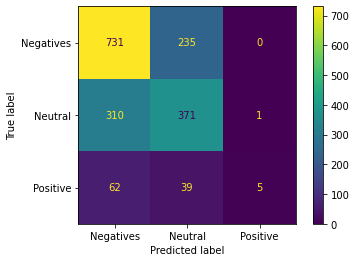

In [69]:
cm_dsp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatives', 'Neutral', 'Positive'])
cm_dsp.plot()

In [70]:
%%time

#predicting 
y_pred = rf_model.predict(X_test.values.astype('U'))

model_score = rf_model.score(X_test.values.astype('U'), y_test.values.astype('int64'))
print(f'Model Score: {model_score}')
print(f'Model Score: {model_score*100:.2f}%')
accuracy = accuracy_score(y_test, y_pred)
print()
print(f"Accuracy: {accuracy}")
print(f"Accuracy: {accuracy*100:.2f}%")
print()
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1-score: {f1}")
print(f"F1-score: {f1*100:.2f}%")
print()
print("CPU times and Wall time: ")

Model Score: 0.6311288483466363
Model Score: 63.11%

Accuracy: 0.6311288483466363
Accuracy: 63.11%

F1-score: 0.4516877538500517
F1-score: 45.17%

CPU times and Wall time: 
CPU times: user 395 ms, sys: 1.92 ms, total: 397 ms
Wall time: 404 ms


In [71]:
# Save to file / directory
joblib_file = "models/Randomforest_model_score_"+ str(round(accuracy*100,2))+".pkl"
joblib.dump(rf_model, joblib_file)

['models/Randomforest_model_score_63.11.pkl']

# 4.3 DECISION TREE CLASSIFIER

In [72]:
# Initialize a vectorization and modelling pipeline
dt_pipeline = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,1))),
     ('tfidf', TfidfTransformer()),
     ('clf', DecisionTreeClassifier()),
 ])

In [73]:
# Algorithm training X_train, X_test, y_train, y_test
dt_model = dt_pipeline.fit(X_train.values.astype('U'), y_train.values.astype('int64'))
dt_model

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', DecisionTreeClassifier())])

In [74]:
y_pred = dt_model.predict(X_test.values.astype('U'))
dt_model.classes_

array([-1,  0,  1])

In [75]:
cm = confusion_matrix(y_test, y_pred, labels=dt_model.classes_)
print(cm)

[[588 331  47]
 [275 384  23]
 [ 56  40  10]]


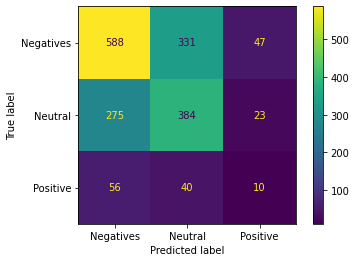

In [76]:
cm_dsp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatives', 'Neutral', 'Positive'])
cm_dsp.plot()

In [77]:
%%time

#predicting 
y_pred = dt_model.predict(X_test.values.astype('U'))

model_score = dt_model.score(X_test.values.astype('U'), y_test.values.astype('int64'))
print(f'Model Score: {model_score}')
print(f'Model Score: {model_score*100:.2f}%')
accuracy = accuracy_score(y_test, y_pred)
print()
print(f"Accuracy: {accuracy}")
print(f"Accuracy: {accuracy*100:.2f}%")
print()
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1-score: {f1}")
print(f"F1-score: {f1*100:.2f}%")
print()
print("CPU times and Wall time: ")

Model Score: 0.5598631698973774
Model Score: 55.99%

Accuracy: 0.5598631698973774
Accuracy: 55.99%

F1-score: 0.42194877495246036
F1-score: 42.19%

CPU times and Wall time: 
CPU times: user 124 ms, sys: 978 µs, total: 125 ms
Wall time: 143 ms


In [78]:
# Save to file / directory
joblib_file = "models/DecisionTreeClassifier_model_score_"+ str(round(accuracy*100,2))+".pkl"
joblib.dump(dt_model, joblib_file)

['models/DecisionTreeClassifier_model_score_55.99.pkl']

# 4.4 KNEIGHBORS CLASSIFIER

In [79]:
# Initialize a vectorization and modelling pipeline
kn_pipeline = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,1))),
     ('tfidf', TfidfTransformer()),
     ('clf', KNeighborsClassifier()), 
 ])

In [80]:
# Algorithm training X_train, X_test, y_train, y_test
kn_model = kn_pipeline.fit(X_train.values.astype('U'), y_train.values.astype('int64'))
kn_model

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', KNeighborsClassifier())])

In [81]:
y_pred = kn_model.predict(X_test.values.astype('U'))
kn_model.classes_

array([-1,  0,  1])

In [82]:
cm = confusion_matrix(y_test, y_pred, labels=kn_model.classes_)
print(cm)

[[615 345   6]
 [266 415   1]
 [ 53  50   3]]


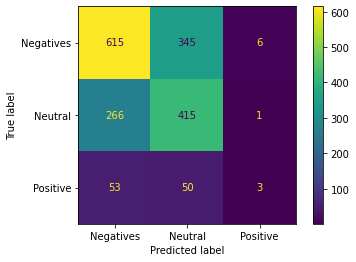

In [83]:
cm_dsp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatives', 'Neutral', 'Positive'])
cm_dsp.plot()

In [84]:
%%time

#predicting 
y_pred = kn_model.predict(X_test.values.astype('U'))

model_score = kn_model.score(X_test.values.astype('U'), y_test.values.astype('int64'))
print(f'Model Score: {model_score}')
print(f'Model Score: {model_score*100:.2f}%')
accuracy = accuracy_score(y_test, y_pred)
print()
print(f"Accuracy: {accuracy}")
print(f"Accuracy: {accuracy*100:.2f}%")
print()
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1-score: {f1}")
print(f"F1-score: {f1*100:.2f}%")
print()
print("CPU times and Wall time: ")

Model Score: 0.5889395667046751
Model Score: 58.89%

Accuracy: 0.5889395667046751
Accuracy: 58.89%

F1-score: 0.4184642756933936
F1-score: 41.85%

CPU times and Wall time: 
CPU times: user 10.4 s, sys: 15.5 ms, total: 10.4 s
Wall time: 5.51 s


In [85]:
# Save to file / directory
joblib_file = "models/KNeighborsClassifier_model_score_"+ str(round(accuracy*100,2))+".pkl"
joblib.dump(kn_model, joblib_file)

['models/KNeighborsClassifier_model_score_58.89.pkl']

# 4.5 LOGISTIC REGRESSION 

In [86]:
# Initialize a vectorization and modelling pipeline
lr_pipeline = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,5))),
     ('tfidf', TfidfTransformer()),
     ('clf', LogisticRegression()), 
 ])

In [87]:
# Algorithm training X_train, X_test, y_train, y_test
lr_model = lr_pipeline.fit(X_train.values.astype('U'), y_train.values.astype('int64'))
lr_model

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 5))),
                ('tfidf', TfidfTransformer()), ('clf', LogisticRegression())])

In [88]:
y_pred = lr_model.predict(X_test.values.astype('U'))
lr_model.classes_

array([-1,  0,  1])

In [89]:
cm = confusion_matrix(y_test, y_pred, labels=lr_model.classes_)
print(cm)

[[782 184   0]
 [303 379   0]
 [ 72  34   0]]


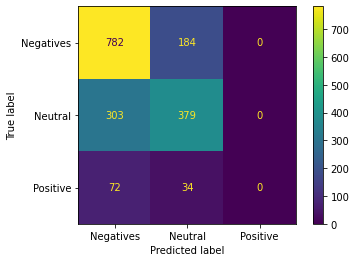

In [90]:
cm_dsp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatives', 'Neutral', 'Positive'])
cm_dsp.plot()

In [91]:
%%time

#predicting 
y_pred = lr_model.predict(X_test.values.astype('U'))

model_score = lr_model.score(X_test.values.astype('U'), y_test.values.astype('int64'))
print(f'Model Score: {model_score}')
print(f'Model Score: {model_score*100:.2f}%')
accuracy = accuracy_score(y_test, y_pred)
print()
print(f"Accuracy: {accuracy}")
print(f"Accuracy: {accuracy*100:.2f}%")
print()
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1-score: {f1}")
print(f"F1-score: {f1*100:.2f}%")
print()
print("CPU times and Wall time: ")

Model Score: 0.6619156214367161
Model Score: 66.19%

Accuracy: 0.6619156214367161
Accuracy: 66.19%

F1-score: 0.4431146222215183
F1-score: 44.31%

CPU times and Wall time: 
CPU times: user 228 ms, sys: 0 ns, total: 228 ms
Wall time: 228 ms


In [92]:
# Save to file / directory
joblib_file = "models/Logistic regression_model_score_"+ str(round(accuracy*100,2))+".pkl"
joblib.dump(kn_model, joblib_file)

['models/Logistic regression_model_score_66.19.pkl']

# 4.6 GRADIENT BOOSTING CLASSIFIER

In [93]:
# Initialize a vectorization and modelling pipeline
gd_pipeline = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,1))),
     ('tfidf', TfidfTransformer()),
     ('clf', GradientBoostingClassifier()), 
 ])

In [94]:
# Algorithm training X_train, X_test, y_train, y_test
gd_model = gd_pipeline.fit(X_train.values.astype('U'), y_train.values.astype('int64'))
gd_model

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', GradientBoostingClassifier())])

In [95]:
y_pred = gd_model.predict(X_test.values.astype('U'))
gd_model.classes_

array([-1,  0,  1])

In [96]:
cm = confusion_matrix(y_test, y_pred, labels=gd_model.classes_)
print(cm)

[[776 184   6]
 [356 322   4]
 [ 69  31   6]]


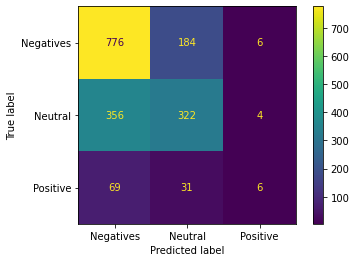

In [97]:
cm_dsp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatives', 'Neutral', 'Positive'])
cm_dsp.plot()

In [98]:
%%time

#predicting 
y_pred = gd_model.predict(X_test.values.astype('U'))

model_score = gd_model.score(X_test.values.astype('U'), y_test.values.astype('int64'))
print(f'Model Score: {model_score}')
print(f'Model Score: {model_score*100:.2f}%')
accuracy = accuracy_score(y_test, y_pred)
print()
print(f"Accuracy: {accuracy}")
print(f"Accuracy: {accuracy*100:.2f}%")
print()
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1-score: {f1}")
print(f"F1-score: {f1*100:.2f}%")
print()
print("CPU times and Wall time: ")

Model Score: 0.629418472063854
Model Score: 62.94%

Accuracy: 0.629418472063854
Accuracy: 62.94%

F1-score: 0.44762001686861286
F1-score: 44.76%

CPU times and Wall time: 
CPU times: user 99.7 ms, sys: 1.12 ms, total: 101 ms
Wall time: 101 ms


In [99]:
# Save to file / directory
joblib_file = "models/GradientBoostingClassifier_model_score_"+ str(round(accuracy*100,2))+".pkl"
joblib.dump(gd_model, joblib_file)

['models/GradientBoostingClassifier_model_score_62.94.pkl']

# 4.7 MULTINOMIALNB

In [100]:
# Initialize a vectorization and modelling pipeline
mnb_pipeline = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,1))),
     ('tfidf', TfidfTransformer()),
     ('clf', MultinomialNB()), 
 ])

In [101]:
# Algorithm training X_train, X_test, y_train, y_test
mnb_model = mnb_pipeline.fit(X_train.values.astype('U'), y_train.values.astype('int64'))
mnb_model

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [102]:
y_pred = mnb_model.predict(X_test.values.astype('U'))
mnb_model.classes_

array([-1,  0,  1])

In [103]:
cm = confusion_matrix(y_test, y_pred, labels=mnb_model.classes_)
print(cm)

[[845 121   0]
 [397 285   0]
 [ 80  26   0]]


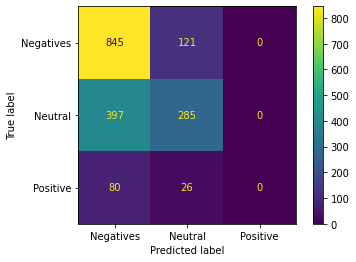

In [104]:
cm_dsp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatives', 'Neutral', 'Positive'])
cm_dsp.plot()

In [105]:
%%time

#predicting 
y_pred = mnb_model.predict(X_test.values.astype('U'))

model_score = mnb_model.score(X_test.values.astype('U'), y_test.values.astype('int64'))
print(f'Model Score: {model_score}')
print(f'Model Score: {model_score*100:.2f}%')
accuracy = accuracy_score(y_test, y_pred)
print()
print(f"Accuracy: {accuracy}")
print(f"Accuracy: {accuracy*100:.2f}%")
print()
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1-score: {f1}")
print(f"F1-score: {f1*100:.2f}%")
print()
print("CPU times and Wall time: ")

Model Score: 0.6442417331812998
Model Score: 64.42%

Accuracy: 0.6442417331812998
Accuracy: 64.42%

F1-score: 0.4167686741744192
F1-score: 41.68%

CPU times and Wall time: 
CPU times: user 117 ms, sys: 0 ns, total: 117 ms
Wall time: 117 ms


In [106]:
# Save to file / directory
joblib_file = "models/MultinomialNB_model_score_"+ str(round(accuracy*100,2))+".pkl"
joblib.dump(mnb_model, joblib_file)

['models/MultinomialNB_model_score_64.42.pkl']

# 4.8 XGBoost classifier

In [107]:
xgb_pipeline = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,1))),
     ('tfidf', TfidfTransformer()),
     ('clf', xgb.XGBClassifier(learning_rate=0.001,
                            max_depth = 1, 
                           n_estimators = 100,)),
 ])

In [108]:
Xg_train = X_train.values.astype('U')
Xg_test = X_test.values.astype('U')
yg_train = y_train
yg_test= y_test

In [109]:
le = LabelEncoder()
yg_train = le.fit_transform(yg_train)

In [110]:
xgbmodel = xgb_pipeline.fit(Xg_train, yg_train)

In [111]:
yg_pred = xgbmodel.predict(Xg_test)
xgbmodel.classes_

array([0, 1, 2])

In [112]:
cm = confusion_matrix(yg_test, yg_pred, labels=xgbmodel.classes_)
print(cm)


[[682   0   0]
 [106   0   0]
 [  0   0   0]]


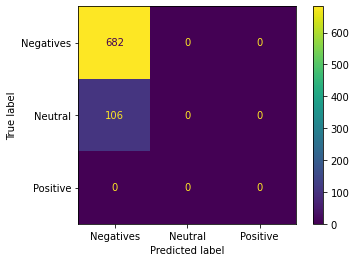

In [113]:
cm_dsp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatives', 'Neutral', 'Positive'])
cm_dsp.plot()
plt.show()

In [114]:
%%time
model_score = xgbmodel.score(X_test.values.astype('U'), y_test.values.astype('int64'))
print(f'Model Score: {model_score}')
print(f'Model Score: {model_score*100:.2f}%')
accuracy = accuracy_score(yg_test, yg_pred)
print()
print(f"Accuracy: {accuracy}")
print(f"Accuracy: {accuracy*100:.2f}%")
print()
f1 = f1_score(yg_test, yg_pred, average='macro')
print(f"F1-score: {f1}")
print(f"F1-score: {f1*100:.2f}%")
print()
print("CPU times and Wall time: ")

Model Score: 0.3888255416191562
Model Score: 38.88%

Accuracy: 0.3888255416191562
Accuracy: 38.88%

F1-score: 0.1866447728516694
F1-score: 18.66%

CPU times and Wall time: 
CPU times: user 60.2 ms, sys: 217 µs, total: 60.4 ms
Wall time: 51.6 ms


In [115]:
# Save to file / directory
joblib_file = "models/XGB_model_score_"+ str(round(accuracy*100,2))+".pkl"
joblib.dump(xgbmodel, joblib_file)

['models/XGB_model_score_38.88.pkl']

# 4.9 LightGBM classifier

In [116]:
lgbm_pipeline = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,1))),
     ('tfidf', TfidfTransformer()),
     ('clf', LGBMClassifier()),  
     ])

In [117]:
# Algorithm training X_train, X_test, y_train, y_test
lgbm_model = lgbm_pipeline.fit(X_train.values.astype('U'), y_train.values.astype('int64'))
lgbm_model

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LGBMClassifier())])

In [118]:
y_pred = lgbm_model.predict(X_test.values.astype('U'))
lgbm_model.classes_

array([-1,  0,  1])

In [119]:
cm = confusion_matrix(y_test, y_pred, labels=lgbm_model.classes_)
print(cm)

[[685 272   9]
 [261 413   8]
 [ 49  44  13]]


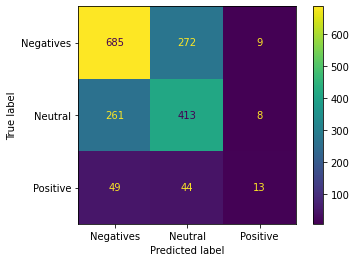

In [120]:
cm_dsp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatives', 'Neutral', 'Positive'])
cm_dsp.plot()

In [121]:
%%time

#predicting 
y_pred = lgbm_model.predict(X_test.values.astype('U'))

model_score = lgbm_model.score(X_test.values.astype('U'), y_test.values.astype('int64'))
print(f'Model Score: {model_score}')
print(f'Model Score: {model_score*100:.2f}%')
accuracy = accuracy_score(y_test, y_pred)
print()
print(f"Accuracy: {accuracy}")
print(f"Accuracy: {accuracy*100:.2f}%")
print()
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1-score: {f1}")
print(f"F1-score: {f1*100:.2f}%")
print()
print("CPU times and Wall time: ")

Model Score: 0.6334093500570125
Model Score: 63.34%

Accuracy: 0.6334093500570125
Accuracy: 63.34%

F1-score: 0.49173334909063615
F1-score: 49.17%

CPU times and Wall time: 
CPU times: user 255 ms, sys: 279 µs, total: 255 ms
Wall time: 160 ms


In [122]:
# Save to file / directory
joblib_file = "models/LGBMClassifier_model_score_"+ str(round(accuracy*100,2))+".pkl"
joblib.dump(lgbm_model, joblib_file)

['models/LGBMClassifier_model_score_63.34.pkl']

# 4.10 CatBoost classifier

In [123]:
ctb_pipeline = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,1))),
     ('tfidf', TfidfTransformer()),
     ('clf', CatBoostClassifier()), 
 ])

In [124]:
# Algorithm training X_train, X_test, y_train, y_test
ctb_model = ctb_pipeline.fit(X_train.values.astype('U'), y_train.values.astype('int64'))
ctb_model

Learning rate set to 0.087391
0:	learn: 1.0685808	total: 480ms	remaining: 7m 59s
1:	learn: 1.0434654	total: 731ms	remaining: 6m 4s
2:	learn: 1.0210969	total: 999ms	remaining: 5m 31s
3:	learn: 1.0004893	total: 1.26s	remaining: 5m 13s
4:	learn: 0.9840040	total: 1.51s	remaining: 5m
5:	learn: 0.9689331	total: 1.77s	remaining: 4m 52s
6:	learn: 0.9555937	total: 2.02s	remaining: 4m 47s
7:	learn: 0.9428873	total: 2.29s	remaining: 4m 43s
8:	learn: 0.9312752	total: 2.54s	remaining: 4m 39s
9:	learn: 0.9226538	total: 2.97s	remaining: 4m 54s
10:	learn: 0.9137327	total: 4.31s	remaining: 6m 27s
11:	learn: 0.9063436	total: 4.77s	remaining: 6m 32s
12:	learn: 0.8991590	total: 5.22s	remaining: 6m 36s
13:	learn: 0.8925933	total: 5.68s	remaining: 6m 40s
14:	learn: 0.8878152	total: 5.94s	remaining: 6m 30s
15:	learn: 0.8826980	total: 6.21s	remaining: 6m 22s
16:	learn: 0.8779936	total: 6.47s	remaining: 6m 14s
17:	learn: 0.8741163	total: 6.73s	remaining: 6m 7s
18:	learn: 0.8710106	total: 6.98s	remaining: 6m
19

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 <catboost.core.CatBoostClassifier object at 0x7f1a2c39fa90>)])

In [125]:
y_pred = ctb_model.predict(X_test.values.astype('U'))
ctb_model.classes_

array([-1,  0,  1])

In [126]:
cm = confusion_matrix(y_test, y_pred, labels=ctb_model.classes_)
print(cm)

[[725 238   3]
 [303 379   0]
 [ 62  41   3]]


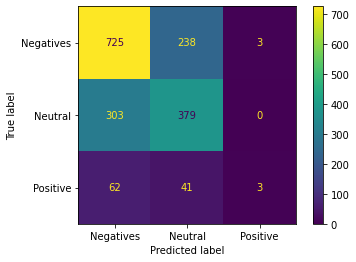

In [127]:
cm_dsp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatives', 'Neutral', 'Positive'])
cm_dsp.plot()

In [128]:
%%time

#predicting 
y_pred = ctb_model.predict(X_test.values.astype('U'))

model_score = ctb_model.score(X_test.values.astype('U'), y_test.values.astype('int64'))
print(f'Model Score: {model_score}')
print(f'Model Score: {model_score*100:.2f}%')
accuracy = accuracy_score(y_test, y_pred)
print()
print(f"Accuracy: {accuracy}")
print(f"Accuracy: {accuracy*100:.2f}%")
print()
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1-score: {f1}")
print(f"F1-score: {f1*100:.2f}%")
print()
print("CPU times and Wall time: ")

Model Score: 0.6311288483466363
Model Score: 63.11%

Accuracy: 0.6311288483466363
Accuracy: 63.11%

F1-score: 0.44149866288347034
F1-score: 44.15%

CPU times and Wall time: 
CPU times: user 334 ms, sys: 120 ms, total: 454 ms
Wall time: 395 ms


In [129]:
# Save to file / directory
joblib_file = "models/CatBoostClassifier_model_score_"+ str(round(accuracy*100,2))+".pkl"
joblib.dump(ctb_model, joblib_file)

['models/CatBoostClassifier_model_score_63.11.pkl']